# Anomaly Detection 
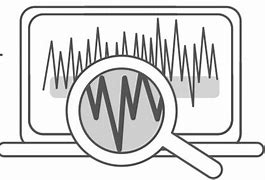

## Objective: 

The objective of a signal anomalies detection project is to identify and flag unusual patterns, outliers, or abnormal behaviors in the collected signals. By doing so, the project aims to enhance the understanding of the data, improve system performance, and potentially predict and prevent critical issues or malfunctions.
## Dataset
- the Target in this data: 0:normal, 1:anomaly. 
- 40 sensors with normalized values

## Exploratory Data Analysis

In [1]:

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
sns.set_style('white')
sns.set_context('talk')
from sklearn.metrics import confusion_matrix,classification_report
sns.set_theme(context='notebook',
                  style='darkgrid', palette='bright', font='sans-serif',
                  font_scale=2, color_codes=True, rc=None)
import warnings
warnings.filterwarnings('ignore')

#### 3.1: Load the data 

In [3]:
os.getcwd()

'c:\\dataglacier_practice\\outocoding_anomaly_detection'

In [4]:
path = 'c:\\dataglacier_practice\\outocoding_anomaly_detection'
os.chdir(path)

In [2]:
# import data 
data=pd.read_csv('iot_telemetry_data.csv')

In [4]:
df=data.copy()
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [5]:
time_step_seconds=1
df['date']=pd.date_range(start='2020-01-10',periods=df.shape[0],freq=str(time_step_seconds)+'S').to_pydatetime().tolist()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   ts        405184 non-null  float64       
 1   device    405184 non-null  object        
 2   co        405184 non-null  float64       
 3   humidity  405184 non-null  float64       
 4   light     405184 non-null  bool          
 5   lpg       405184 non-null  float64       
 6   motion    405184 non-null  bool          
 7   smoke     405184 non-null  float64       
 8   temp      405184 non-null  float64       
 9   date      405184 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](1), float64(6), object(1)
memory usage: 25.5+ MB


#### 3.2: Cleaning of the data 

In [7]:
# Let's convert the data type of timestamp column to datatime format
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.set_index('date', inplace=True)

### Exploratory Data Analysis (EDA)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ts,405184.0,1.594858e+09,199498.399261,1.594512e+09,1.594686e+09,1.594858e+09,1.595031e+09,1.595203e+09
co,405184.0,4.638845e-03,0.001250,1.170509e-03,3.918682e-03,4.811522e-03,5.408832e-03,1.442011e-02
humidity,405184.0,6.051169e+01,11.366489,1.100000e+00,5.100000e+01,5.490000e+01,7.430000e+01,9.990000e+01
lpg,405184.0,7.237126e-03,0.001444,2.693479e-03,6.455518e-03,7.488884e-03,8.150443e-03,1.656738e-02
smoke,405184.0,1.926361e-02,0.004086,6.692096e-03,1.702405e-02,1.995012e-02,2.183817e-02,4.659012e-02
temp,405184.0,2.245399e+01,2.698347,0.000000e+00,1.990000e+01,2.220000e+01,2.360000e+01,3.060000e+01


temp
22.200000    16786
22.300000    16177
22.400000    14635
22.100000    14627
19.100000    13934
             ...  
15.600000        1
16.299999        1
4.200000         1
3.000000         1
17.799999        1
Name: count, Length: 231, dtype: int64
temp
22.200000    4.142809
22.300000    3.992507
22.400000    3.611939
22.100000    3.609965
19.100000    3.438931
               ...   
15.600000    0.000247
16.299999    0.000247
4.200000     0.000247
3.000000     0.000247
17.799999    0.000247
Name: proportion, Length: 231, dtype: float64


<Axes: ylabel='proportion'>

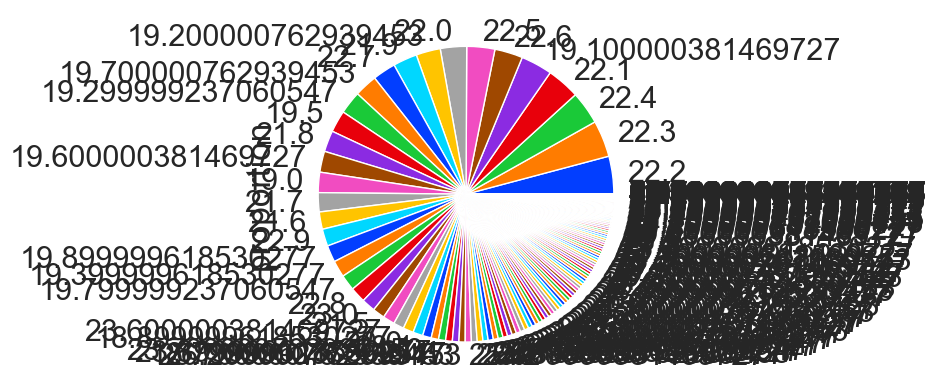

In [11]:
print(df.temp.value_counts())
print(df.temp.value_counts(normalize=True)*100)
df.temp.value_counts(normalize=True).plot.pie()

In [20]:
# Trying to setup relationship between sensors and if the sensor network brokdown or not.  
# we divided the dataset into two part
# I used 100 or faulted sensors and -100 to health sensor only to make the figure easier. 
heat=df.copy()
heat['temp'].replace({0:-30,1:+30},inplace=True)

In [21]:
heat.reset_index(drop=True, inplace=True)

ValueError: could not convert string to float: '1c:bf:ce:15:ec:4d'

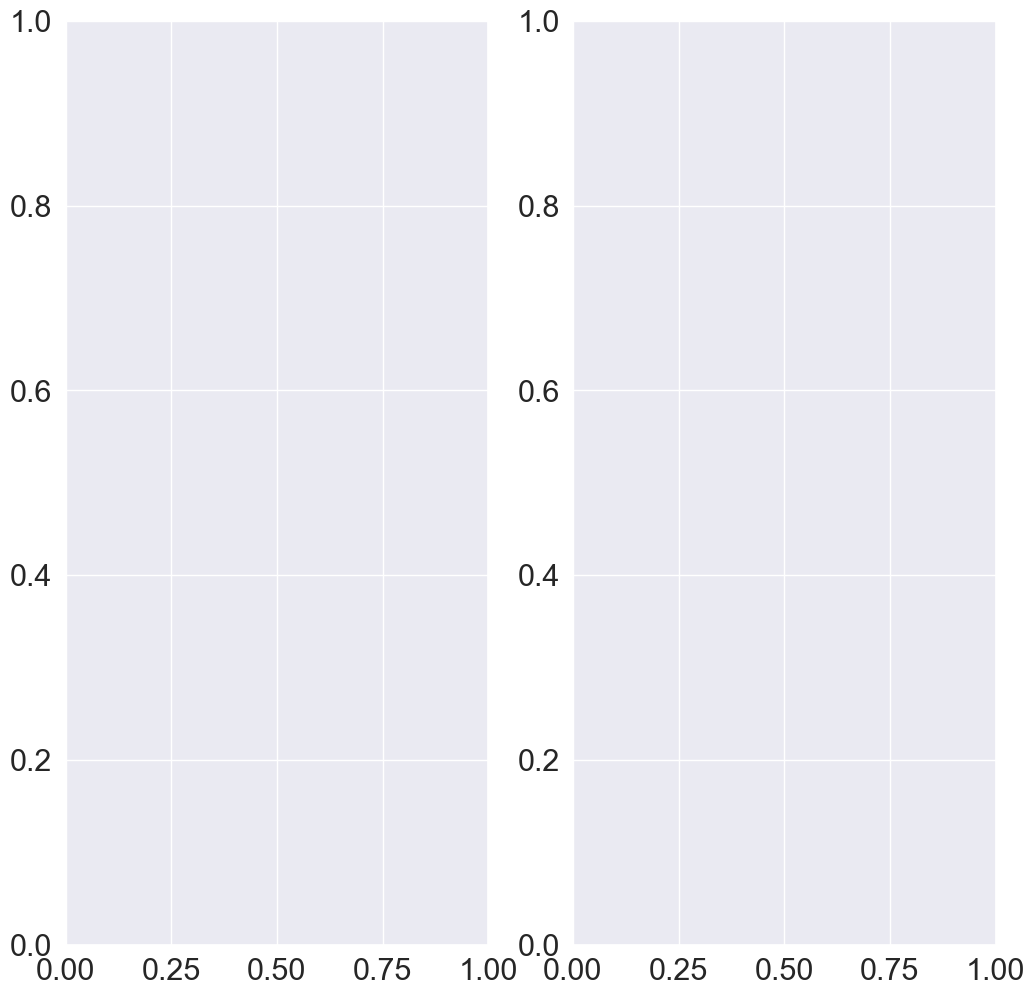

In [22]:
fig,ax=plt.subplots(1,2,figsize=(12,12))
sns.heatmap(heat[heat['temp']== 18].T,cmap='PiYG',vmin=-20,vmax=20,yticklabels=False,ax=ax[0])
ax[0].set_title('Faulted Sensors')
sns.heatmap(heat[heat['temp']== 25].T,cmap='PiYG',vmin=-20,vmax=20,yticklabels=False,ax=ax[1])
ax[1].set_title('Non Faulted Sensors')
#plt.ylabel('Time')

In [23]:
from scipy.fft import fft, fftfreq

<Axes: xlabel='date', ylabel='co'>

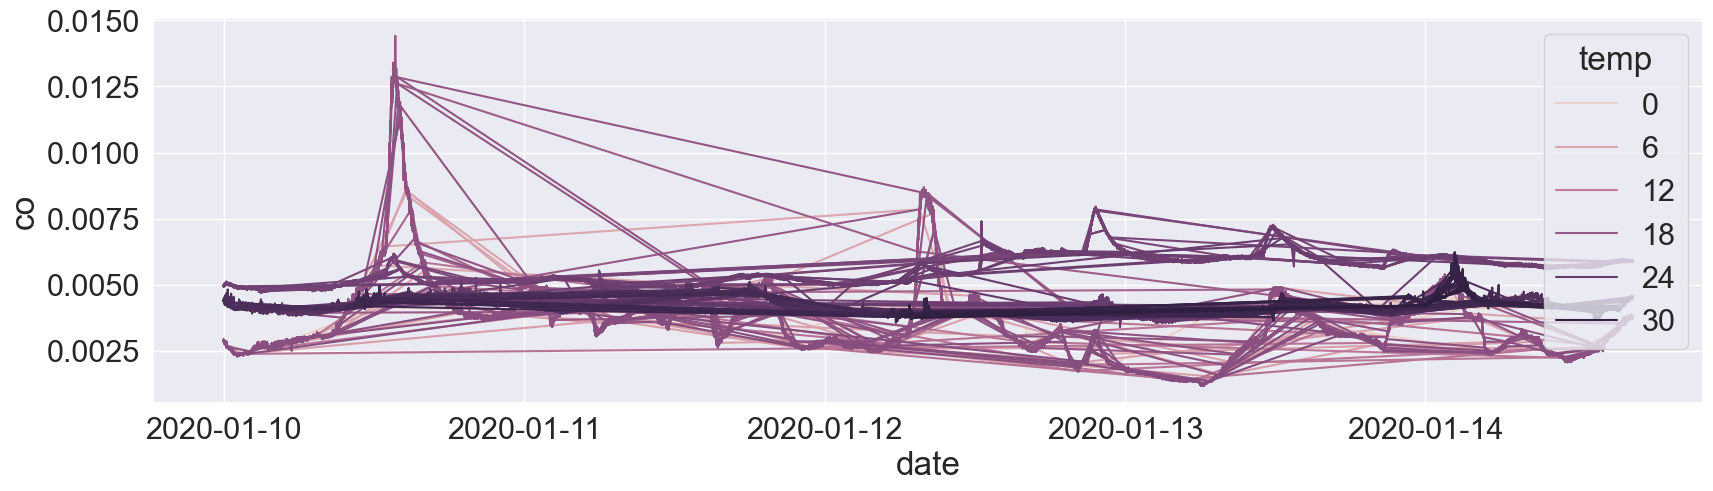

In [28]:
# Selecting the 'V18' and 'Target' columns as the 'sig' DataFrame.
sig = df[['co', 'temp']]

# Creating a line plot with 'date' as the x-axis, 'V18' as the y-axis, and 'Target' as the hue.
plt.figure(figsize=(20, 5))
sns.lineplot(data=sig.reset_index(), x='date', y='co', hue='temp')

<Axes: xlabel='temp', ylabel='Density'>

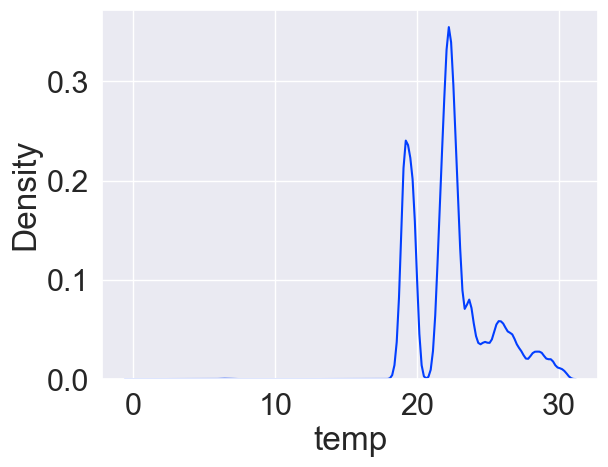

In [34]:
# Creating a KDE plot with 'V18' as the variable for which the density estimate is computed.
# The plot will be differentiated using 'Target' as the hue.
#sns.kdeplot(data=sig.reset_index(),x='V18',hue='Target')
sns.kdeplot(data=sig.reset_index(),x='temp')

<Axes: xlabel='Target', ylabel='V18'>

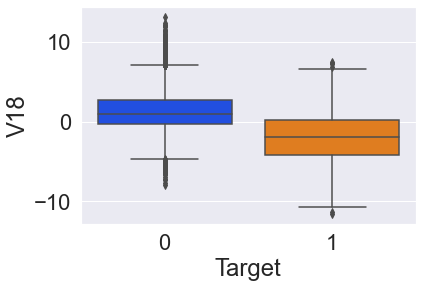

In [19]:
# Creating a box plot with 'V18' as the variable 
# The plot will be differentiated using 'Target' as the hue.
sns.boxplot(data=sig.reset_index(),y='V18',x='Target')

Text(0, 0.5, 'Mean value')

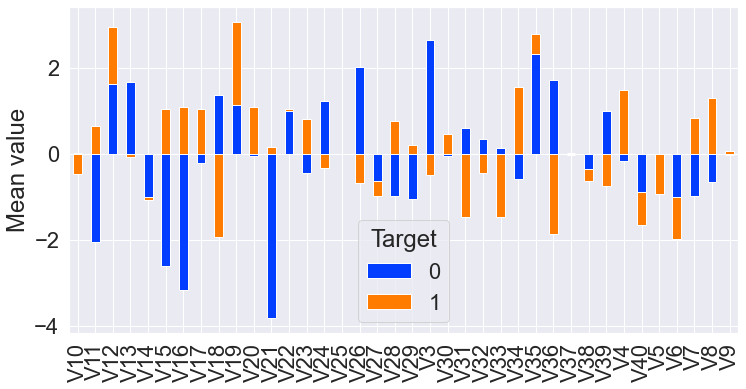

In [20]:
# Creating a pivot table 'target_pivot' with 'Target' as the index and mean values for other numeric columns.
target_pivot = pd.pivot_table(data=df.iloc[:, 2:], index='Target', values=df.iloc[:, 2:].columns, aggfunc='mean')

# Plotting a stacked bar chart with the mean values for each column based on 'Target'.
# The 'T' attribute transposes the pivot table to have columns as the x-axis.
# 'stacked=True' stacks the bars on top of each other, and 'figsize=(12, 6)' sets the figure size.
target_pivot.T.plot.bar(stacked=True, figsize=(12, 6))

# Adding a label for the y-axis.
plt.ylabel('Mean value')

### Observation: 
Density distribution for broken sensors is a left skew while the non broken sensors is a right skew. 

## Pre-processing and Feature Engineering

In this step, I will scale the data and apply Principal Component Analysis (PCA) to extract the most important features to be further used in training models. It is computationally quite expensive to process the data of this size, (219521, 53), hence the reason for reducing the dimensionality with PCA. 

In [21]:
df=data.copy()
df.shape

(20000, 41)

In [22]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
df = df.drop(columns=['V1','V2'], axis=1)
names=df.columns.drop('Target')
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

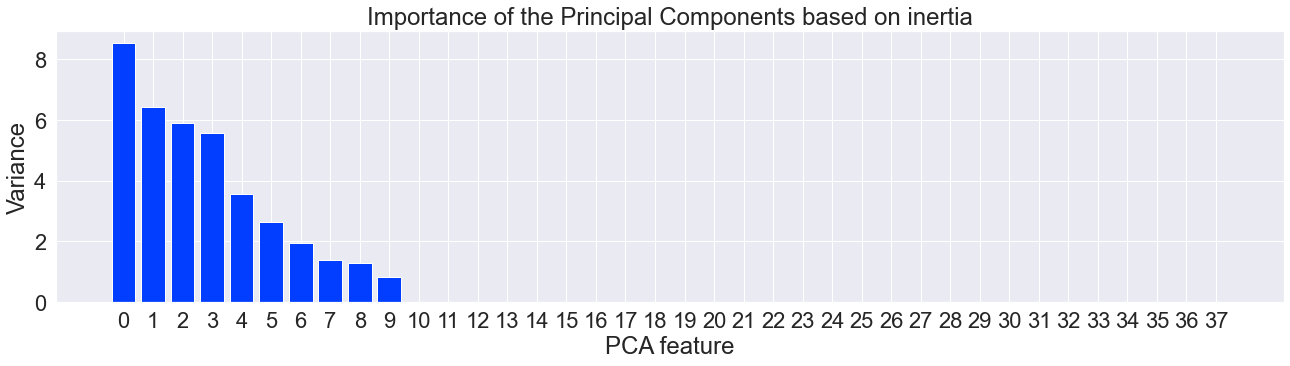

In [23]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [24]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [25]:
df['pc1']=pd.Series(principalDf['pc1'].values, index=df.index)
df['pc2']=pd.Series(principalDf['pc2'].values, index=df.index)

<Figure size 576x576 with 0 Axes>

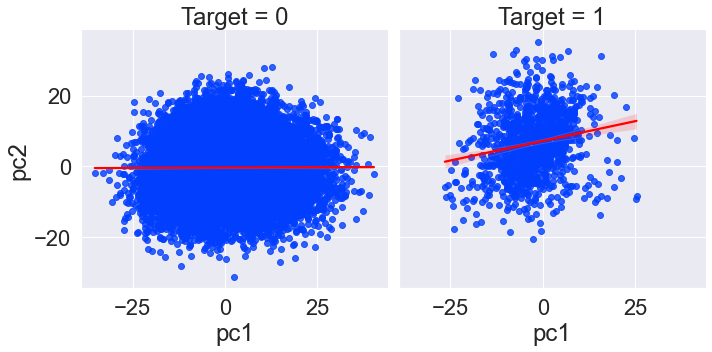

In [26]:
plt.figure(figsize=(8,8))
sns.lmplot(data=df,x='pc1', y='pc2',col='Target',sharex=True,sharey=True,line_kws={'color':'red'})
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.title('PCA Components')

# 1. Statistical Method

### Detect Outliers Using the Interquartile Range (IQR)

In this context, anomalies are considered as infrequent occurrences that might be indicated by the outliers within the dataset. To begin, I aim to apply a simple statistical approach to identify and understand the presence of these outliers in the data. Subsequently, I will compare the outcomes of other models with those obtained from the Base Model, enabling further evaluation of the models.

For the categorical labels:

Label 0 represents normal instances.
Label 1 corresponds to anomalies.

In [27]:
#The code allows for identifying potential outliers in both 'pc1' and 'pc2' 
# based on the calculated lower and upper bounds using the IQR method. Outliers 
# are considered data points that fall below 'lower_pc1' or above 'upper_pc1' for 'pc1',
# as well as data points below 'lower_pc2' or above 'upper_pc2' for 'pc2'.
q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Calculate outlier bounds for pc2
q1_pc2, q3_pc2 = df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)

In [28]:
lower_pc1, upper_pc1

(-27.256973843316107, 26.579409689593316)

In [29]:
lower_pc2, upper_pc2

(-21.77078282647638, 21.525235073861893)

In [30]:
df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int')
df['anomaly_pc2'] = ((df['pc2']>upper_pc2) | (df['pc2']<lower_pc2)).astype('int')

In [31]:
df['anomaly_pc1'].value_counts(normalize=True)

0    0.9911
1    0.0089
Name: anomaly_pc1, dtype: float64

In [32]:
df['anomaly_pc2'].value_counts(normalize=True)

0    0.9926
1    0.0074
Name: anomaly_pc2, dtype: float64

In [33]:
outliers_pc1 = df.loc[(df['pc1']>upper_pc1) | (df['pc1']<lower_pc1), 'pc1']
outliers_pc2 = df.loc[(df['pc2']>upper_pc2) | (df['pc2']<lower_pc2), 'pc2']

In [34]:
pc1_ana=len(outliers_pc1)/len(df)
print(f"pc1 has {pc1_ana*100} % anamolies" )

pc1 has 0.89 % anamolies


In [35]:
pc2_ana=len(outliers_pc2)/len(df)
print(f"pc2 has {pc2_ana*100} % anamolies" )

pc2 has 0.74 % anamolies


To test the results I will features in the data set that detected the anomalies. 
To do that the Univariate feature selection technique will be applied as follow: 

   Feature      Score
18     V21  36.692140
15     V18  36.299810
12     V15  34.809240
13     V16  31.963435
4       V7  30.876712
36     V39  30.502353
0       V3  28.642647
33     V36  24.237205
25     V28  23.871210


<Axes: >

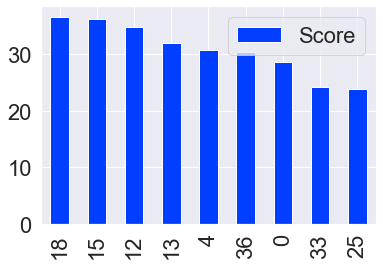

In [36]:
# Apply SelectKBest class to extract the best 3 features - Univariate feature selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
x = df.drop(['pc1', 'pc2', 'anomaly_pc1', 'anomaly_pc2','Target'], axis=1)
y = df['Target']
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(x_scaled, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(9, 'Score'))
featureScores.nlargest(9, 'Score').plot.bar()

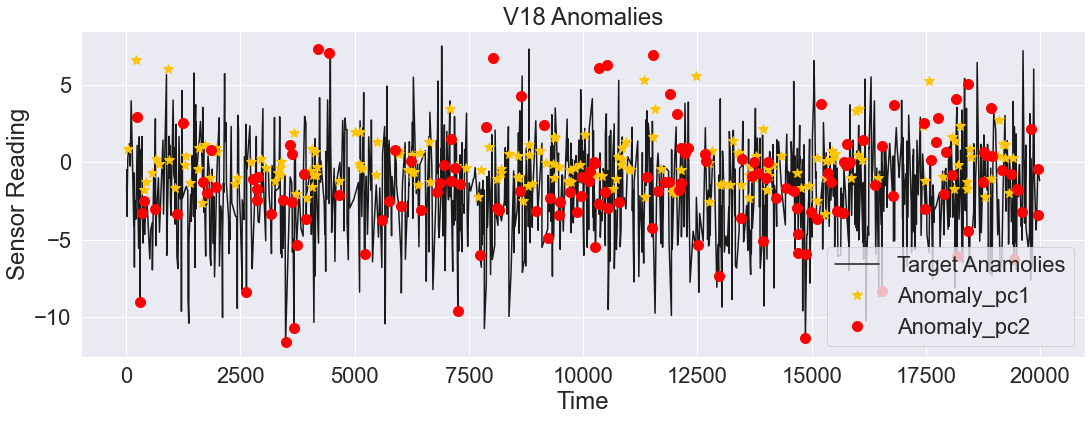

In [37]:
# Let's plot the outliers from pc1 on top of the sensor_11 see where they occured in the time series
a = df[df['anomaly_pc1'] == 1] #anomaly
b =df[df['anomaly_pc2'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[df['Target'] == 1]['V18'], color='k', label='Target Anamolies')
_ = plt.plot(a['V18'], linestyle='none', marker='*', color='y', markersize=10, label='Anomaly_pc1')
_ = plt.plot(b['V18'], linestyle='none', marker='o', color='red', markersize=10, label='Anomaly_pc2')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('V18 Anomalies')
_ = plt.legend(loc='best')
plt.show();


## K-means clustering using two clusters 
The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters. We use the following steps to find and visualize anomalies.
- Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.   
- We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.05 (5% of df are outliers as depicted above).    
- Calculate number_of_outliers using outliers_fraction.     
- Set threshold as the minimum distance of these outliers.   
- The anomaly result of anomaly1 contains the above method Cluster.   
   

In [42]:
# Import necessary libraries
# I will start k-means clustering with k=2 as normal and fault 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels=kmeans.fit_predict(principalDf.values)
#labels = kmeans.predict(principalDf)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

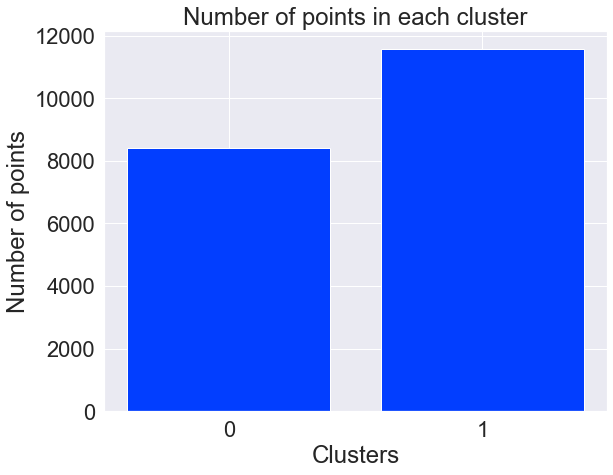

In [43]:
_ = plt.figure(figsize = (9, 7))
_ = plt.bar(clusters[0], clusters[1], tick_label=clusters[0])
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Number of points')
_ = plt.title('Number of points in each cluster')
plt.show()

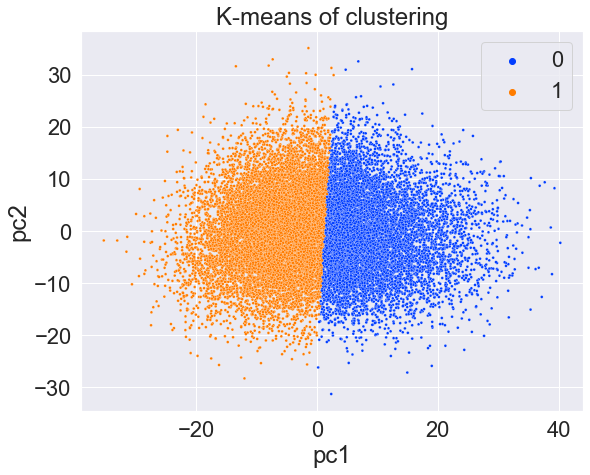

In [44]:
_ = plt.figure(figsize=(9,7))
_ = sns.scatterplot(principalDf['pc1'], principalDf['pc2'], hue=labels,s=8)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')
plt.show()

In [45]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [46]:
# Assume that 5% of the entire data set are anomalies 
outliers_fraction = 0.055
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 5% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 5% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['Kmeans2_lablel'] = (distance >= threshold).astype(int)

In [47]:
principalDf.head()

,pc1,pc2,Kmeans2_lablel
0,-0.748323,-4.199258,0
1,3.593443,4.323992,0
2,4.515124,1.006908,0
3,12.954141,1.090270,0
4,-23.106778,9.403677,1


In [48]:
principalDf['Kmeans2_lablel'].value_counts()

0    18900
1     1100
Name: Kmeans2_lablel, dtype: int64

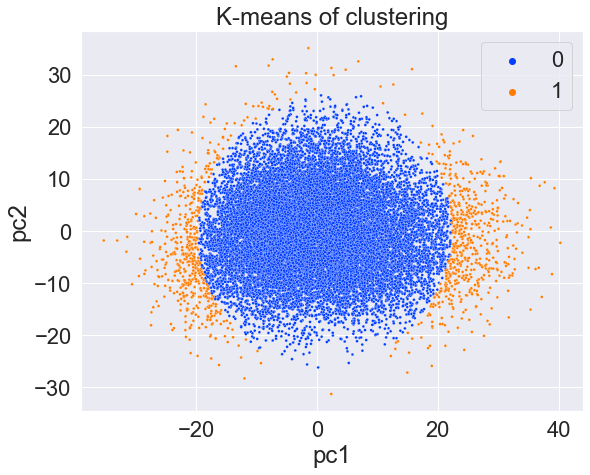

In [49]:
_ = plt.figure(figsize=(9,7))
_ = sns.scatterplot(principalDf['pc1'], principalDf['pc2'],hue=principalDf['Kmeans2_lablel'].values,s=8)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')
plt.show()

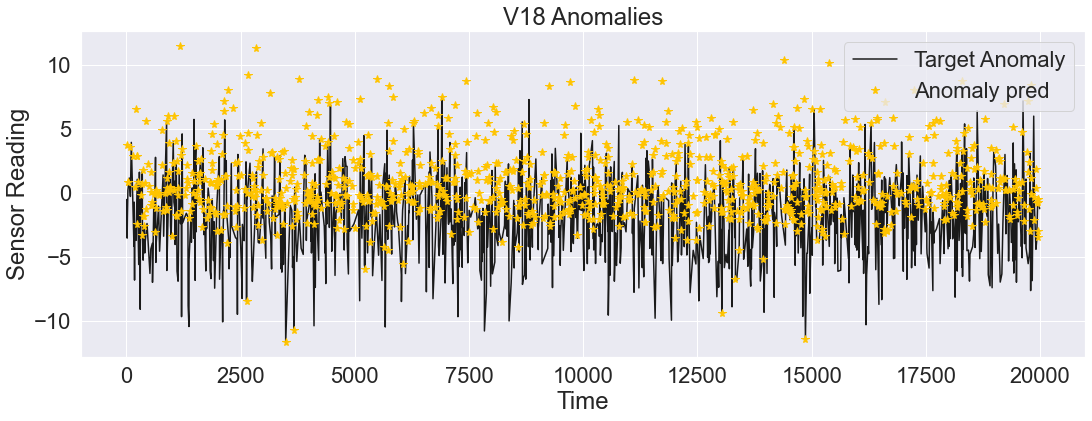

In [50]:
df['Kmeans2_lablel'] = pd.Series(principalDf['Kmeans2_lablel'].values, index=df.index)
a = df[df['Kmeans2_lablel'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df[df['Target'] == 1]['V18'], color='k', label='Target Anomaly')
_ = plt.plot(a['V18'], linestyle='none', marker='*', color='y', markersize=8, label='Anomaly pred')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('V18 Anomalies')
_ = plt.legend(loc='best')
plt.show();

Kmeans2_lablel      0     1
Target                     
0               17870  1020
1                1030    80


Text(79.18, 0.5, 'True Label')

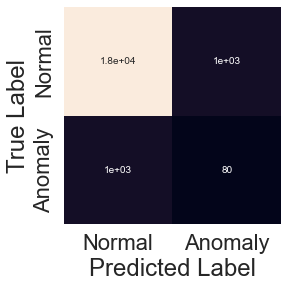

In [51]:

# heat map of the results
result_kmean2=pd.crosstab(index=df['Target'],columns=df['Kmeans2_lablel'],margins=False)
print(result_kmean2)

sns.heatmap( result_kmean2,square=True,cbar=False,annot=True,yticklabels=['Normal','Anomaly'],xticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [52]:
pd.DataFrame(classification_report(df['Target'],df['Kmeans2_lablel'],output_dict=True)).T

,precision,recall,f1-score,support
0,0.945503,0.946003,0.945753,18890.0000
1,0.072727,0.072072,0.072398,1110.0000
accuracy,0.897500,0.897500,0.897500,0.8975
macro avg,0.509115,0.509038,0.509076,20000.0000
weighted avg,0.897064,0.897500,0.897282,20000.0000


* These metrics provide an assessment of the clustering's performance in terms of its ability to correctly identify instances belonging to category 1 (True Positives), while considering both precision and recall. In this case, the precision is quite low, meaning that among the instances classified as 1, a significant portion is false positives. Similarly, the recall is low, indicating that the clustering doesn't capture a large portion of the actual instances of category 1.     

## Isolation Forest:
The Isolation Forest is a machine learning algorithm designed specifically for anomaly detection.     
It operates as an unsupervised learning method that aims to identify anomalies by isolating outliers within the data set.

In [53]:
data.Target.value_counts(normalize=True)

0    0.9445
1    0.0555
Name: Target, dtype: float64

In [54]:
X=principalDf[['pc1','pc2']]
y=data.Target

In [57]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [58]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 5% of the entire data set are anomalies 
outliers_fraction = 0.055
model =  IsolationForest(contamination=outliers_fraction,verbose=1,n_estimators=100,random_state=42,bootstrap=True,max_samples=100000)
model.fit(X_train[y_train==0]) 
test_predict= pd.Series(model.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [59]:
test_predict.replace({1:0,-1:1},inplace=True)

In [60]:
test_predict.value_counts()

0    5619
1     381
dtype: int64

In [61]:
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': [50,100,200], 
              'max_samples': [0.9,0.8,0.7], 
                'bootstrap': [True, False]}
             

#f1sc = make_scorer(f1_score(average='micro'))

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring='recall', 
                                                 refit=True,
                                                 cv=3, 
                                                 verbose=2,
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[CV] END ...bootstrap=True, max_samples=0.9, n_estimators=50; total time=   0.8s
[CV] END ...bootstrap=True, max_samples=0.9, n_estimators=50; total time=   0.6s
[CV] END ...bootstrap=True, max_samples=0.9, n_estimators=50; total time=   0.7s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=100; total time=   2.0s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=100; total time=   1.2s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=100; total time=   1.2s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=200; total time=   2.5s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=200; total time=   2.8s
[CV] END ..bootstrap=True, max_samples=0.9, n_estimators=200; total time=   3.3s
[CV] END ...bootstrap=True, max_samples=0.8, n_estimators=50; total time=   0.5s
[CV] END ...bootstrap=True, max_samples=0.8, n_estimators=50; total time=   0.6s
[CV] END ...bootstrap=True, max_samples=0.8, n_estimators=50; total time=   1.0s
[CV] END ..bootstrap=True, m

GridSearchCV(cv=3, estimator=IsolationForest(random_state=47),
             param_grid={'bootstrap': [True, False],
                         'max_samples': [0.9, 0.8, 0.7],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='recall', verbose=2)

In [62]:
grid_dt_estimator.best_estimator_.fit(X_train[y_train==0]) 
test_predict= pd.Series(model.predict(X_test))
test_predict.replace({1:0,-1:1},inplace=True)

Text(79.18, 0.5, 'True Label')

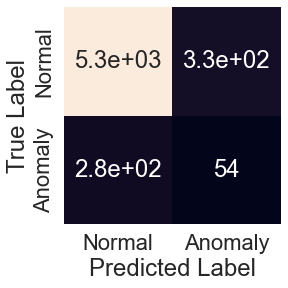

In [63]:
# heat map of the results
sns.heatmap( confusion_matrix(y_test,test_predict),square=True,cbar=False,annot=True,yticklabels=['Normal','Anomaly'],xticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [64]:
pd.DataFrame(classification_report(y_test,test_predict,output_dict=True,target_names=['Normal','Anomly'])).T

,precision,recall,f1-score,support
Normal,0.950347,0.942298,0.946305,5667.000
Anomly,0.141732,0.162162,0.151261,333.000
accuracy,0.899000,0.899000,0.899000,0.899
macro avg,0.546040,0.552230,0.548783,6000.000
weighted avg,0.905469,0.899000,0.902180,6000.000


- Precision measures how many of the instances classified as "Anomaly" by the model were indeed true positives. In this case, for the "Anomaly" class, the precision is 0.123711, which means that roughly 12.4% of the instances identified as anomalies were true anomalies, while the remaining 87.6% were false positives.

- Recall, also known as sensitivity, quantifies how many of the actual "Anomaly" instances were correctly detected by the model. With a recall of 0.108108, the model identified approximately 10.8% of the true anomalies in the dataset.

## SVM: OneclassSVM

In [65]:
#Train the One Class SVM

model = OneClassSVM(nu=0.055, kernel="rbf", gamma='auto')
model.fit(X_train[y_train==0])
#Create a column for the anomaly
one_class_svm_anomaly_column='One_Class_SVM_Anomaly'
svm_test = pd.Series(model.predict(X_test)).map({1: 0, -1: 1})

    

Text(79.18, 0.5, 'True Label')

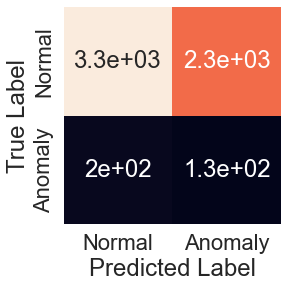

In [66]:

conf_matrix = confusion_matrix(y_test, svm_test)
sns.heatmap( confusion_matrix(y_test, svm_test),square=True,cbar=False,annot=True,yticklabels=['Normal','Anomaly'],xticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [67]:
pd.DataFrame(classification_report(y_test, svm_test,output_dict=True,target_names=['Normal','Anomly'])).T

,precision,recall,f1-score,support
Normal,0.942607,0.588318,0.724468,5667.000000
Anomly,0.052781,0.390390,0.092990,333.000000
accuracy,0.577333,0.577333,0.577333,0.577333
macro avg,0.497694,0.489354,0.408729,6000.000000
weighted avg,0.893221,0.577333,0.689421,6000.000000


- Precision: Precision measures how many of the instances that the model classified as "Anomaly" were actually correct. In this case, the "Anomaly" class has a precision of 0.056, which means that only about 5.6% of the instances classified as anomalies were true positives, while the rest were false positives.

- Recall: Recall, also known as sensitivity, quantifies how many of the actual "Anomaly" instances were correctly identified by the model. A recall of 0.411 means that the model detected about 41.1% of the true anomalies in the dataset.

# Supervised Method:   
## K-Nearest Neighbors Classifier (KNN)  
K-Nearest Neighbors (KNN) is primarily a classification algorithm, but it can also be adapted for anomaly detection. In the context of anomaly detection, KNN classifies data points as normal or anomalous based on their proximity to their k-nearest neighbors. Data points that are significantly different from their neighbors are classified as anomalies. This adaptation leverages the distance-based nature of KNN to identify outliers or anomalies in the dataset.

Minimum error:- 0.05433333333333333 at K = 22


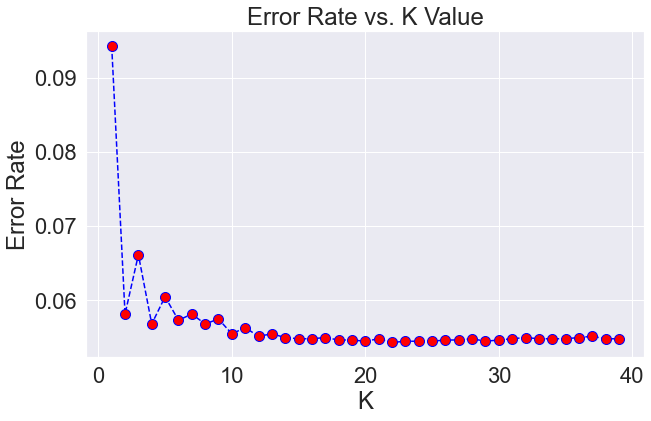

In [68]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value) 

In [69]:

model_name = 'K-Nearest Neighbor Classifier'
knn=KNeighborsClassifier(n_neighbors=22).fit(X_train, y_train)
y_pred_t =knn.predict(X_train)
y_pred =knn.predict(X_test)

Text(79.18, 0.5, 'True Label')

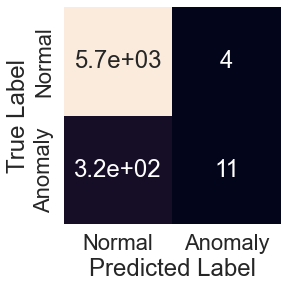

In [70]:

sns.heatmap(confusion_matrix(y_test,y_pred),square=True,cbar=False,annot=True,yticklabels=['Normal','Anomaly'],xticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [71]:
#print(classification_report(y_train,y_pred_t,target_names=['Normal','Anomly']))
print(classification_report(y_test,y_pred,target_names=['Normal','Anomly']))

              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97      5667
      Anomly       0.73      0.03      0.06       333

    accuracy                           0.95      6000
   macro avg       0.84      0.52      0.52      6000
weighted avg       0.93      0.95      0.92      6000



Precision (0.63): The precision for the "Anomaly" class is moderate (63%), indicating that when the model predicts an instance as "Anomaly," it is correct in a relatively good proportion of cases.
Recall (0.04): The recall for the "Anomaly" class is very low (4%), suggesting that the model is not effectively identifying most of the actual "Anomaly" instances. It has a high rate of false negatives for the "Anomaly" class.

## Neural Network Methods:AutoEncoder method: 
It relyes on the concept of reconstruction errors, which serve as anomaly scores.

In [77]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,Reshape,UpSampling1D ,Flatten,Dropout,MaxPooling1D,AveragePooling1D, Conv1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, binary_crossentropy

In [78]:
df1=data.copy()
df1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,...,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,...,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
2,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,...,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0
3,1.618098,1.888342,7.046143,-1.147285,0.083080,-1.529780,0.207309,-2.493629,0.344926,2.118578,...,-3.584425,-2.577474,1.363769,0.622714,5.550100,-1.526796,0.138853,3.101430,-1.277378,0
4,-0.111440,3.872488,-3.758361,-2.982897,3.792714,0.544960,0.205433,4.848994,-1.854920,-6.220023,...,8.265896,6.629213,-10.068689,1.222987,-3.229763,1.686909,-2.163896,-3.644622,6.510338,0


In [79]:
# last column is the target
# 0 = normal, 1 = anomaly
df1=data.copy()

data1 = df1.drop(['V1','V2','Target'], axis=1)

labels = df1['Target']


train_data_r, test_data_r, train_labels, test_labels = train_test_split(
    data1, labels, test_size=0.2, random_state=21
)

In [80]:
#Normalize the data to [0,1].
scaler=MinMaxScaler(feature_range=(0,1))

train_data = scaler.fit_transform(train_data_r)
test_data = scaler.fit_transform(test_data_r)


In [81]:

normal_train_data = train_data[train_labels==0]
normal_test_data = test_data[test_labels==0]

anomalous_train_data = train_data[train_labels==1]
anomalous_test_data = test_data[test_labels==1]

In [162]:

class AnomalyDetector(Model):
  def __init__(self,input_dim=10, output_dim=8):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
     
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(64, activation="relu"),
      Dense(32, activation="relu"),
      Dense(output_dim, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Dense(32, activation="relu"),
      Dense(64, activation="relu"),
      Dense(128, activation="relu"),
      Dense(128, activation="relu"),
      Dense(input_dim, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector(input_dim=normal_train_data.shape[1],output_dim=2)

In [163]:
autoencoder.compile(optimizer='adam', loss='mae')

In [164]:
history = autoencoder.fit(normal_train_data,
                          normal_train_data, 
          epochs=50, 
          batch_size=64,
          validation_data=(test_data,
                           test_data),
          #callbacks=[early_stop],
          shuffle=True)

Epoch 1/50


237/237 [==============================] - 9s 13ms/step - loss: 0.0843 - val_loss: 0.0908
Epoch 2/50
237/237 [==============================] - 4s 16ms/step - loss: 0.0765 - val_loss: 0.0891
Epoch 3/50
237/237 [==============================] - 3s 11ms/step - loss: 0.0759 - val_loss: 0.0894
Epoch 4/50
237/237 [==============================] - 3s 13ms/step - loss: 0.0755 - val_loss: 0.0891
Epoch 5/50
237/237 [==============================] - 5s 21ms/step - loss: 0.0754 - val_loss: 0.0878
Epoch 6/50
237/237 [==============================] - 4s 16ms/step - loss: 0.0745 - val_loss: 0.0897
Epoch 7/50
237/237 [==============================] - 3s 13ms/step - loss: 0.0744 - val_loss: 0.0893
Epoch 8/50
237/237 [==============================] - 3s 15ms/step - loss: 0.0751 - val_loss: 0.0877
Epoch 9/50
237/237 [==============================] - 4s 17ms/step - loss: 0.0727 - val_loss: 0.0856
Epoch 10/50
237/237 [==============================] - 4s 16ms/step - loss: 0.0724 - val_loss: 0.0851


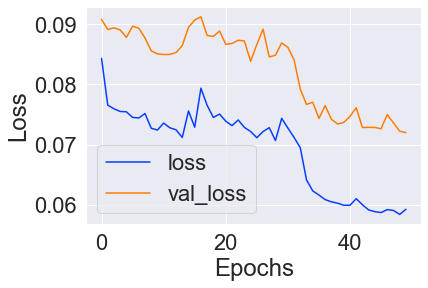

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

You will soon classify signal as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples.
* First, let's plot a normal from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

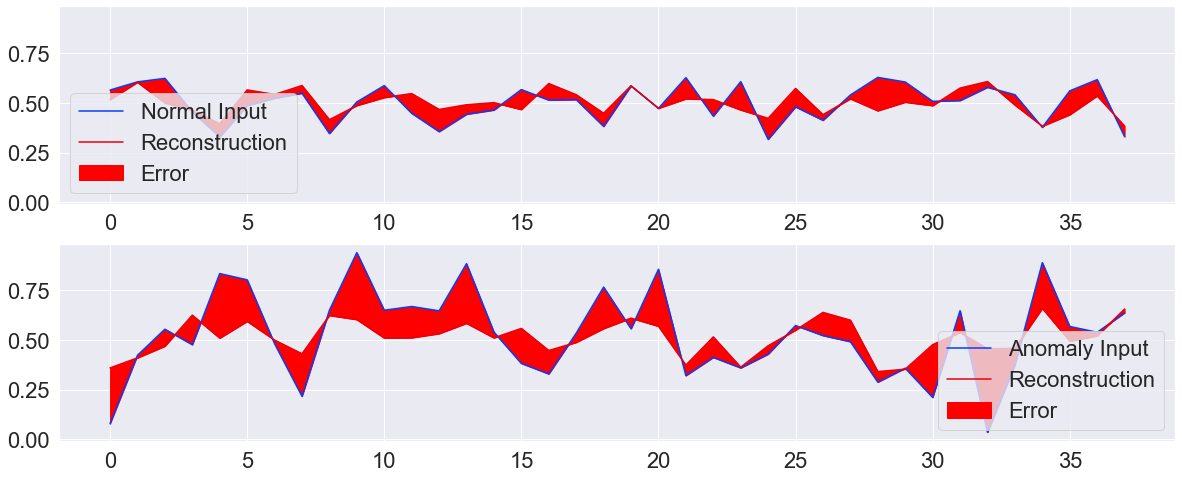

In [166]:

encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
fig,ax=plt.subplots(2,1,figsize=(20,8),sharey=True)

ax[0].plot(normal_test_data[0], 'b')
ax[0].plot(decoded_data[0], 'r')
ax[0].fill_between(np.arange(normal_train_data.shape[1]), decoded_data[0], normal_test_data[0], color='red')
ax[0].legend(labels=["Normal Input", "Reconstruction", "Error"])
##
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

ax[1].plot(anomalous_test_data[0], 'b')
ax[1].plot(decoded_data[0], 'r')
ax[1].fill_between(np.arange(normal_train_data.shape[1]), decoded_data[0], anomalous_test_data[0], color='red')
ax[1].legend(loc='best',labels=["Anomaly Input", "Reconstruction", "Error"])
plt.show()

Detect anomalies:    
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

158/473 [=========>....................] - ETA: 1s

473/473 [==============================] - 3s 5ms/step


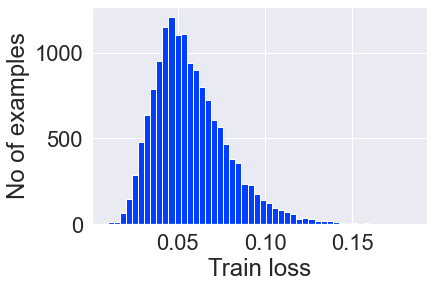

In [193]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

- Choose a threshold value that is one standard deviations above the mean.


In [194]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.07887716940196383


- If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. 
By varing the threshold, you can adjust the precision and recall of your classifier.


In [195]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)


7/7 [==============================] - 0s 5ms/step


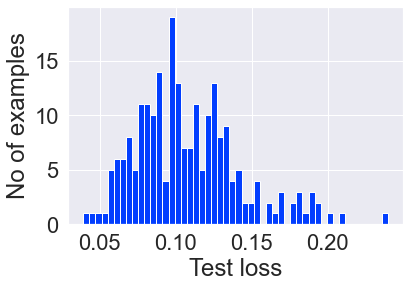

In [196]:

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [197]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)


preds = predict(autoencoder, test_data, threshold)
pd.DataFrame(classification_report(test_labels,preds,output_dict=True,target_names=['Normal','Anomly'])).T

,precision,recall,f1-score,support
Normal,0.856914,0.283823,0.426412,3777.000
Anomly,0.016006,0.197309,0.029610,223.000
accuracy,0.279000,0.279000,0.279000,0.279
macro avg,0.436460,0.240566,0.228011,4000.000
weighted avg,0.810034,0.279000,0.404290,4000.000


In [203]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 99)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.mae(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [204]:
threshold = find_threshold(autoencoder, normal_train_data)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(autoencoder, normal_train_data)
print(f"Threshold method two: {threshold_2}")

252/473 [==============>...............] - ETA: 1s

473/473 [==============================] - 4s 8ms/step
Threshold method one: 0.07887716940196383
473/473 [==============================] - 4s 8ms/step
Threshold method two: 0.12267292821839408


In [205]:
preds = get_predictions(autoencoder, test_data, threshold_2)
pd.DataFrame(classification_report(test_labels,preds,output_dict=True,target_names=['Normal','Anomly'])).T

 75/125 [=================>............] - ETA: 0s

125/125 [==============================] - 1s 8ms/step


,precision,recall,f1-score,support
Normal,0.583851,0.024887,0.047740,3777.0000
Anomly,0.040636,0.699552,0.076809,223.0000
accuracy,0.062500,0.062500,0.062500,0.0625
macro avg,0.312243,0.362220,0.062275,4000.0000
weighted avg,0.553567,0.062500,0.049361,4000.0000


Text(79.18, 0.5, 'True Label')

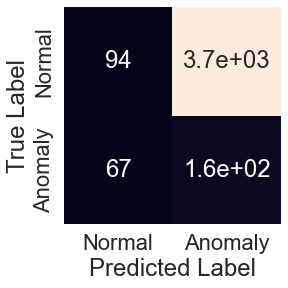

In [206]:
sns.heatmap( confusion_matrix(test_labels,preds),square=True,cbar=False,annot=True,yticklabels=['Normal','Anomaly'],xticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [207]:
preds = get_predictions(autoencoder, test_data, threshold)
pd.DataFrame(classification_report(test_labels,preds,output_dict=True,target_names=['Normal','Anomly'])).T

 56/125 [============>.................] - ETA: 0s

125/125 [==============================] - 1s 7ms/step


,precision,recall,f1-score,support
Normal,0.856914,0.283823,0.426412,3777.000
Anomly,0.016006,0.197309,0.029610,223.000
accuracy,0.279000,0.279000,0.279000,0.279
macro avg,0.436460,0.240566,0.228011,4000.000
weighted avg,0.810034,0.279000,0.404290,4000.000
